# Métodos de Runge-Kutta Adaptativos

In [1]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt

# Método RK4 Adaptativo

In [2]:
def rk4a(start: float, end: float, func: Callable, eps: float, x0: (float | np.ndarray), h0: float=1e-6, el: bool=False) -> tuple[np.ndarray, np.ndarray]:
    """
        Resolve a equação diferencial `dx/dt = func(x, t)` usando o método de Runge-Kutta Adaptativo de Ordem 4 começando em `start` e terminando em `end` com erro total `eps` sendo `x(start) = x0` e sendo o primeiro passo de comprimento `h0`. Usa extrapolação local se `el` for `True`.

        A função `func` deve aceitar dois argumentos: um float `x` e um float `t`. O argumento `x0` deve também ser um float.

        ### Retorno
        tt: Array com os valores da variável independente `t`
        xx: Array com os resultados em função de `t`
    """

    # Número de variáveis em jogo
    nvars = 1 if len(np.array(x0).shape) == 0 else len(np.array(x0))

    # Erro por unidade de tempo
    delta = eps / (end - start)

    # Array onde vamos guardar a solução final
    tt = [start]
    xx = [x0]

    # Passo RK4
    def passo(xn: (float | np.ndarray), tn: float, func: Callable, h: float) -> (float | np.ndarray):
        k1 = func(xn, tn)
        k2 = func(xn + h/2 * k1, tn + h/2)
        k3 = func(xn + h/2 * k2, tn + h/2)
        k4 = func(xn + h * k3, tn + h)
        
        return xn + h * (k1 + 2*k2 + 2*k3 + k4)/6
    

    # Ajustar h de forma limitada (não permitir que h mais que duplique)
    def novoh(velhoh: float, rho: float) -> float:
        valorh, limiteh = velhoh * rho**(1/4), 2 * velhoh
        return valorh if abs(valorh) < abs(limiteh) else limiteh


    # Valor inicial de x, t e de h
    xstart = x0
    tstart = start
    h = h0

    toend = False
    while True:
        # Dois passos de tamanho h
        xtemp = passo(xstart, tstart, func, h)
        x1h = passo(xtemp, tstart + h, func, h)

        # Um passo de tamanho 2h
        x2h = passo(xstart, tstart, func, 2 * h)

        epsvars = []
        if nvars == 1:
            # Calcular erro num passo
            epspasso = (x1h - x2h) / 30

        else:
            # Calcular erros em cada variável
            epsvars = np.array(abs(x1h - x2h) / 30)
            
            # Expressão para o erro total, depende do problema!
            epspasso = np.sqrt(np.sum(epsvars ** 2))

        # Calcular rho
        rho = float(abs(h * delta) / abs(epspasso))

        # A precisão foi melhor que o necessário
        if rho > 1:
            # Guardar os valores
            if el:
                tt += [tstart + h, tstart + 2 * h]
                if nvars == 1:
                    xx += [xtemp + epspasso, x1h + 2 * epspasso]
                else:
                    xx += [xtemp + epsvars, x1h + 2 * epsvars]
            else:
                tt += [tstart + h, tstart + 2 * h]
                xx += [xtemp, x1h]

            # Avançar o tempo
            tstart = tt[-1]
            xstart = xx[-1]
            
            # Ajustar h
            h = novoh(h, rho)

            if toend:
                break

        # A precisão foi pior que o necessário
        else:
            # Ajustar h
            # Aqui multiplicamos por 0.99 para evitar que caso rho ~ 1 o valor de h não se altere e o programa entre em loop infinito
            h = 0.99 * novoh(h, rho)

            # Afinal não deve terminar ainda pois o h não era bom o suficiente
            toend = False
            
        
        # Certificar que há um ponto em t = end
        if (h > 0 and tstart + 2 * h >= end) or (h < 0 and tstart + 2 * h <= end):
            # Selecionar um h adequado (será sempre menor ou igual ao h atual, pelo que o programa irá de facto terminar!)
            h = (end - tstart) / 2
            
            # Flag para terminar o processo na próxima iteração
            toend = True
    
    return np.array(tt), np.array(xx)

## Testar os Métodos

Vamos verificar que os métodos funcionam, considerando a seguinte equação diferencial:

$$
\frac{dx}{dt} = -0.5x \quad\quad x(0) = 1
$$

Cuja solução exata é:

$$
x(t) = e^{-0.5t}
$$

In [3]:
# Lado direito da equação
def f(x, t):
    return -0.5 * x

# Solução exata
def exato(t):
    return np.exp(-0.5 * t)


# Parâmetro
a, b = 0, 10


tt = np.linspace(a, b, 1000)
xx = exato(tt)

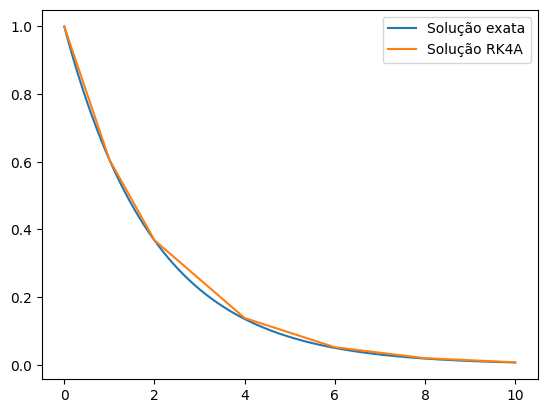

In [4]:
ttrk4a, xxrk4a = rk4a(a, b, f, 0.1, 1, h0=1)

plt.plot(tt, xx, label="Solução exata")
plt.plot(ttrk4a, xxrk4a, label="Solução RK4A")
plt.legend()
plt.show()

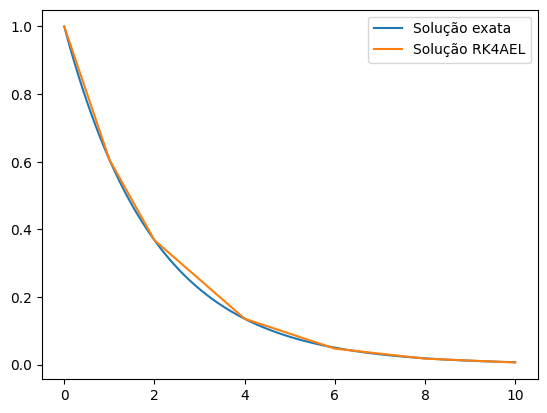

In [5]:
ttrk4ael, xxrk4ael = rk4a(a, b, f, 0.1, 1, h0=1, el=True)

plt.plot(tt, xx, label="Solução exata")
plt.plot(ttrk4ael, xxrk4ael, label="Solução RK4AEL")
plt.legend()
plt.show()

# Testar para Sistemas de ODEs

Com base no exercício 2. da ficha 7

In [6]:
def f(r: np.ndarray, t: float) -> np.ndarray:
    alpha, beta, gamma, delta = 1, 0.5, 0.5, 2
    x, y = r[0], r[1]

    return np.array([alpha * x - beta * x * y, gamma * x * y - delta * y])

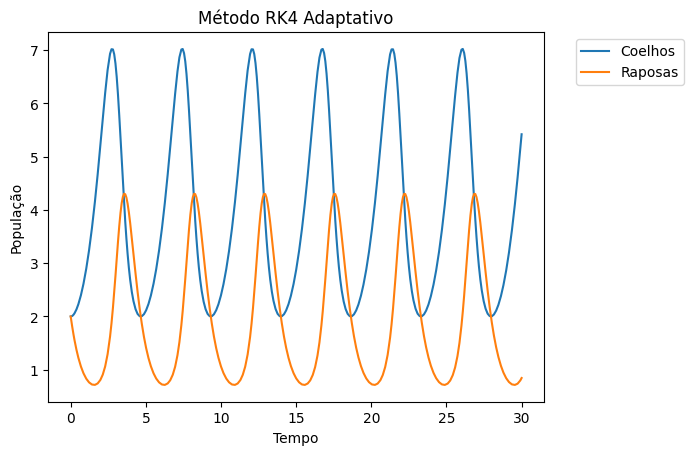

In [7]:
tt, sol = rk4a(0, 30, f, 0.001, np.array([2, 2]), h0=0.001)
xx = np.array([item[0] for item in sol])
yy = np.array([item[1] for item in sol])

plt.title("Método RK4 Adaptativo")
plt.plot(tt, xx, label="Coelhos")
plt.plot(tt, yy, label="Raposas")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("Tempo")
plt.ylabel("População")
plt.show()